# Evaluate on experimental data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from lib import pipeline
from lib import data_gen
import importlib
importlib.reload(pipeline)
from mlreflect.models import DefaultTrainedModel, TrainedModel
from mlreflect.data_generation import ReflectivityGenerator
from mlreflect.training import InputPreprocessor, OutputPreprocessor
import tensorflow as tf
from tensorflow import keras
from mlreflect.curve_fitter import CurveFitter
from mlreflect.data_generation import interp_reflectivity

PARAMETERS = ["Film_thickness", "Film_roughness", "Film_sld"]
matplotlib.rcParams.update({
    "font.size": 20,
    "boxplot.boxprops.color": "gray",
    "boxplot.patchartist":True,
    "boxplot.showfliers": False,
    "boxplot.notch": False,
    "boxplot.medianprops.color": "firebrick",
    "patch.facecolor": "lightgray"
                         })

In [2]:
noise_level=0.1
BATCH_SIZE=256

In [3]:
# model_cnn = keras.models.load_model(
#     'models/current_state_models/0.001_0.0_100_100_50_12_8_512_20220627-183255')
# model_cnn = keras.models.load_model(
#     'models/current_state_models/0.001_0.2_100_100_50_12_8_512_20220705-194014')

model_cnn = keras.models.load_model(
    'models3l/0.1_25_50_75_12_8_4_256_20220719-091356')

mean_labels, std_labels = np.loadtxt(
    "data/mean_labels.csv"), np.loadtxt("data/std_labels.csv")
mean_data, std_data = np.loadtxt(
    f"data/mean_data_{noise_level}.csv"), np.loadtxt(f"data/std_data_{noise_level}.csv")

In [4]:
def predict():
    q_values_used_for_training = DefaultTrainedModel().q_values
    sample = DefaultTrainedModel().sample
    model_mlp = DefaultTrainedModel()
    keras_mlp=DefaultTrainedModel().keras_model
    param_clean_test_list=[]
    test_refl_lst, test_q_values_lst, test_lables_lst = data_gen.iterate_experiments()
    for experiment in test_lables_lst:
        for param_set in zip(np.atleast_1d(experiment[0]).tolist(), np.atleast_1d(experiment[1]).tolist(), np.atleast_1d(experiment[2]).tolist()):
            param_clean_test_list.append(param_set)
    th_lst_cnn, rh_lst_cnn, sld_lst_cnn, mse_errors_cnn, log_error_cnn = pipeline.test_on_exp_data_pipeline(
        test_refl_lst, test_q_values_lst, test_lables_lst, q_values_used_for_training, "CNN", sample, model_cnn, noise_level, mean_labels, std_labels, mean_data, std_data)
    th_lst_mlp, rh_lst_mlp, sld_lst_mlp, mse_errors_mlp, log_error_mlp = pipeline.test_on_exp_data_pipeline(
        test_refl_lst, test_q_values_lst, test_lables_lst, q_values_used_for_training, "MLP", sample, model_mlp, noise_level, mean_labels, std_labels, mean_data, std_data)
    return th_lst_cnn, rh_lst_cnn, sld_lst_cnn, mse_errors_cnn, th_lst_mlp, rh_lst_mlp, sld_lst_mlp, mse_errors_mlp, param_clean_test_list, log_error_cnn, log_error_mlp


In [5]:
th_lst_cnn, rh_lst_cnn, sld_lst_cnn, mse_errors_cnn, th_lst_mlp, rh_lst_mlp, sld_lst_mlp, mse_errors_mlp, param_clean_test_list, log_errors_cnn, log_errors_mlp=predict()

CNN
Exp median param error: (16.510632077215913, 2.279762164475222, 0.7585082513118184)
Exp mse median: 0.0484346617013216
Exp log error median: 0.2817502745891721
MLP
Exp median param error: (6.420808236166586, 1.7280227407821087, 0.7923502203934687)
Exp mse median: 0.029282337985932827
Exp log error median: 0.14872638190621726


In [6]:
def visualize_experimental_performance(th_lst_cnn, rh_lst_cnn, sld_lst_cnn, mse_errors_cnn, th_lst_mlp, rh_lst_mlp, sld_lst_mlp, mse_errors_mlp, param_clean_test_list, log_errors_cnn, log_errors_mlp):
    fig_boxplot, axs_boxplot = plt.subplots(1)
    fig_log_error, axs_log_error=plt.subplots(1)
    fig_boxplots_param_errors, axs_boxplots_param_errors = plt.subplots(
        2, 3, figsize=(15, 10))
    axs_boxplot.set_title("Comparison of MSE-Errors")
    axs_log_error.set_title("Comparison of log-Errors (back-sim.)")
    #mse
    axs_boxplot.boxplot(
        [mse_errors_mlp, mse_errors_cnn])
    axs_boxplot.set_xticklabels(["MLP", "CNN"])
    #log error
    axs_log_error.boxplot([log_errors_mlp, log_errors_cnn])
    axs_log_error.set_xticklabels(["MLP", "CNN"])
    for param_idx, (box, param_lst_cnn, param_lst_mlp) in enumerate(zip(axs_boxplots_param_errors[0,:], [th_lst_cnn, rh_lst_cnn, sld_lst_cnn], [th_lst_mlp, rh_lst_mlp, sld_lst_mlp])):
        #absolute errors
        box.boxplot(
            [param_lst_mlp, param_lst_cnn], positions=[1, 2])
        if param_idx is not 2:
            box.set_ylabel("Absolute error in $\mathrm{\AA}$")
        else:
            box.set_ylabel("Absolute error in $\mathrm{10^{-6} \AA^{-2}}$")
        if param_idx==0:
            box.set_title("Film Thickness")
        if param_idx==1:
            box.set_title("Film Roughness")
        if param_idx==2:
            box.set_title("Film SLD")    
        box.set_xticklabels(["MLP", "CNN"])
    for param_idx, (box, param_lst_cnn, param_lst_mlp) in enumerate(zip(axs_boxplots_param_errors[1,:], [th_lst_cnn, rh_lst_cnn, sld_lst_cnn], [th_lst_mlp, rh_lst_mlp, sld_lst_mlp])):
        nominator_cnn=np.array(param_lst_cnn)
        nominator_mlp=np.array(param_lst_mlp)
        denominator=np.array(param_clean_test_list)[:,param_idx]
        #relative errors
        box.boxplot(
            [np.absolute(100*nominator_mlp/denominator), np.absolute(100*nominator_cnn/denominator)],  positions=[1, 2], showfliers=False
        )
        
        box.set_xticklabels(["MLP", "CNN"])
        box.set_ylabel("Relative error in %")

    fig_boxplot.tight_layout()
    fig_boxplots_param_errors.tight_layout()
    
    # fig_boxplots_param_errors.savefig("../fig/exp_perf/param_errors_exp_comp.pdf", dpi=fig_boxplots_param_errors.dpi)
    # fig_boxplot.savefig("../fig/exp_perf/mse_error_exp_comp.pdf", dpi=fig_boxplots_param_errors.dpi)

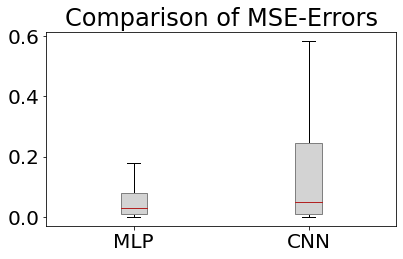

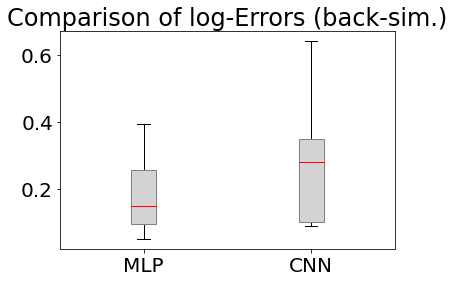

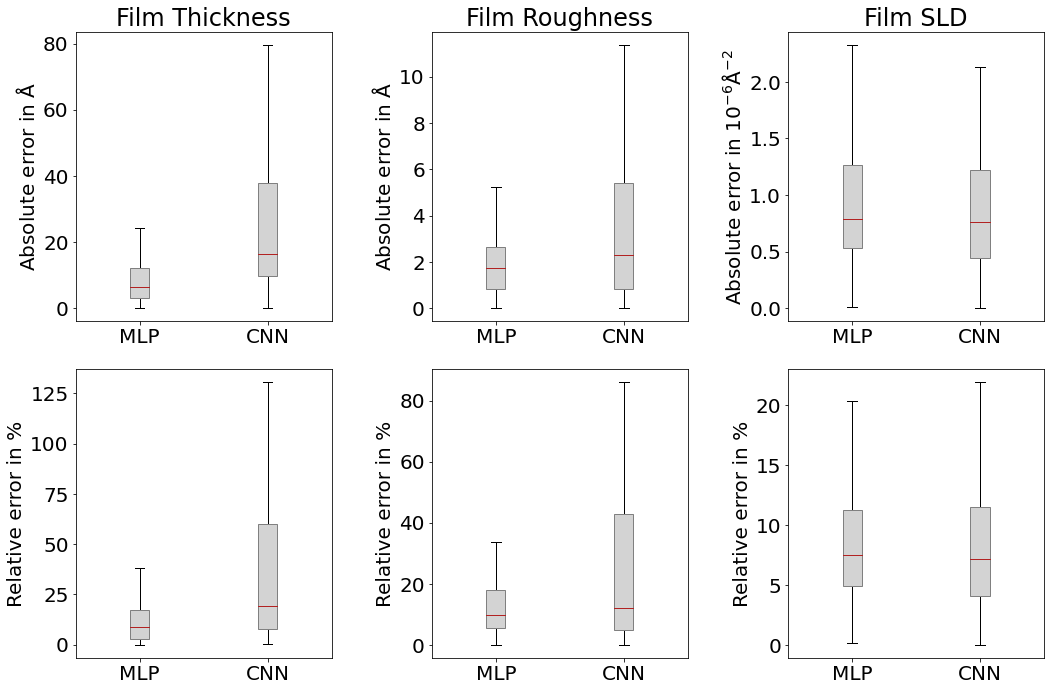

In [7]:
visualize_experimental_performance(th_lst_cnn, rh_lst_cnn, sld_lst_cnn, mse_errors_cnn, th_lst_mlp, rh_lst_mlp, sld_lst_mlp, mse_errors_mlp, param_clean_test_list, log_errors_cnn, log_errors_mlp)